In [ ]:
!zip -r train.zip train

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import random
import os
import cv2 as cv

In [1]:
!mkdir train

In [ ]:
ROOT = "./dataset"
# DATASET_SIZE = 1000
dirs = ["zero", "one", "two", "three", "four", "five", "undefined"]
datasize = {"zero": 5000, "one": 5000, "two": 5000, "three": 5000, "four": 3000, "five": 2000, "undefined": 1000}
train = 'train'
data = {"id":[], "digit": []}

for idx, dir in enumerate(dirs):
  path = os.path.join(ROOT, dir)
  for i in range(0, datasize[dir]):
    path = os.path.join(ROOT, dir, "{}.jpg".format(i))
    img = np.asarray(image.imread(path))
    
    hash = random.getrandbits(128)
    filename = "%032x.jpg" % hash
    data['id'].append(filename)
    path = os.path.join(train, filename)
    cv.imwrite(path, img)
    data['digit'].append(idx)

    print(idx, i)

df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.count()

id       26000
digit    26000
dtype: int64

In [8]:
df.to_csv("train.csv")

In [ ]:
# X, y = load_data()
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# print(np.mean(X_train))
# print(np.mean(X_test))
# print(np.std(X_train))
# print(np.std(X_test))
# train = 'train'
# data = {"id":[], "digit": []}
# for image, label in zip(X, y):
#   hash = random.getrandbits(128)
#   filename = "%032x.jpg" % hash
#   data['id'].append(filename)
#   path = os.path.join(train, filename)
#   cv.imwrite(path, image)
#   data['digit'].append(label)
# df = pd.DataFrame(data)
# df.to_csv("train.csv")

NameError: ignored

In [2]:
class digitDataset(Dataset):
  def __init__(self, data, path , transform = None):
    super().__init__()
    self.data = data.values
    self.path = path
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index):
    img_name,label = self.data[index]
    img_path = os.path.join(self.path, img_name)
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if self.transform is not None:
        image = self.transform(image)
    return image, label

In [3]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([7.524291],[43.089508])])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([7.524291],[43.089508])])

In [4]:
labels = pd.read_csv(r'train.csv')
labels = labels.sample(frac=1).reset_index(drop=True)
del labels['Unnamed: 0']
train, valid_data = train_test_split(labels, stratify=labels.digit, test_size=0.1)

In [5]:
train_path = r'train'
train_data = digitDataset(train, train_path, train_transform)
valid_data = digitDataset(valid_data, train_path, valid_transform)

In [18]:
# Hyper parameters
num_epochs = 13
batch_size = 25
learning_rate = 0.0001

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [20]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(1200, 100),
            Linear(100, 50),
            Linear(50, 7)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# defining the model
model = Net().to(device)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = CrossEntropyLoss()

In [22]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.053806 	Validation Loss: 0.722749
Epoch: 2 	Training Loss: 0.600911 	Validation Loss: 0.522601
Epoch: 3 	Training Loss: 0.460197 	Validation Loss: 0.427502
Epoch: 4 	Training Loss: 0.362198 	Validation Loss: 0.345104
Epoch: 5 	Training Loss: 0.296830 	Validation Loss: 0.315800
Epoch: 6 	Training Loss: 0.250317 	Validation Loss: 0.269692
Epoch: 7 	Training Loss: 0.216260 	Validation Loss: 0.247898
Epoch: 8 	Training Loss: 0.189359 	Validation Loss: 0.228144
Epoch: 9 	Training Loss: 0.172166 	Validation Loss: 0.219321
Epoch: 10 	Training Loss: 0.155827 	Validation Loss: 0.213562
Epoch: 11 	Training Loss: 0.144617 	Validation Loss: 0.206277
Epoch: 12 	Training Loss: 0.134072 	Validation Loss: 0.200337
Epoch: 13 	Training Loss: 0.128097 	Validation Loss: 0.188278
CPU times: user 23min 17s, sys: 1min 43s, total: 25min 1s
Wall time: 25min 5s


In [27]:
 # test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


Test Accuracy of the model: 94.61538461538461 %


In [ ]:
94.61538461538461

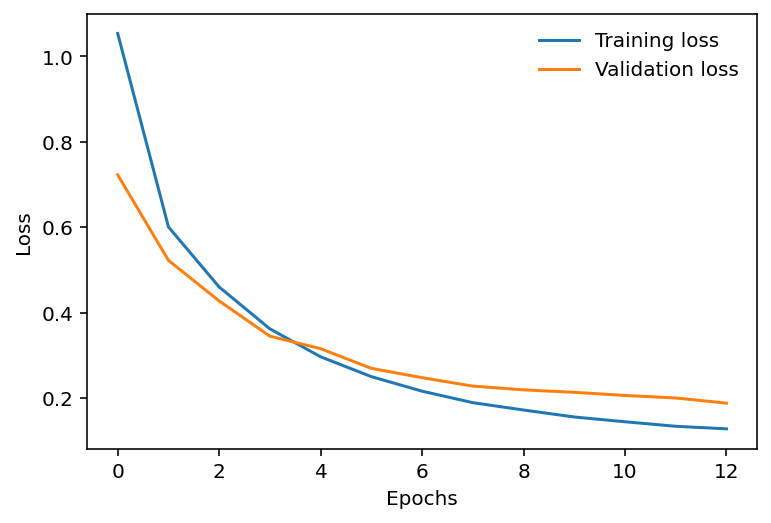

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [25]:
# Save 
torch.save(model.state_dict(), 'model_95.ckpt')